<a href="https://colab.research.google.com/github/custom-hyper/Analytics/blob/main/Trading_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Environment

In [60]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
#@title Install Dependencies
!pip install statistics --quiet
!pip install yfinance --quiet
!pip install pytrends --quiet
!pip install pycoingecko --quiet
!pip install pandas --quiet
!pip install Backtesting --quiet
!pip install mplfinance --quiet
!pip install configparser --quiet
!pip install psycopg2-binary==2.8.6 --quiet
!pip install tweepy

#@title Ta-lib – Extra steps { display-mode: "code" }
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb 
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb 
!pip install ta-lib --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(Reading database ... 124041 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


In [62]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import mplfinance as fplt
from datetime import datetime as dt
from datetime import timedelta
from datetime import date
import talib as ta
import time
import json
import seaborn as sns
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
#from __future__ import division

In [63]:
#@title Set up SQLite { display-mode: "code" }
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [64]:
#@title  Load Watchlist { display-mode: "code" }

proprietary_watchlist_hist = 'proprietary_watchlist_hist'

df = pd.read_sql('select * from {}'.format(proprietary_watchlist_hist), conn_SQLite)

conn_SQLite.close()

df

,id,symbol,name,market_cap,price_change_percentage_24h,float_rotation_24h,dilution_ratio,vendor_last_update,watchlist_name,query_date,query_timestamp,note_catalyst,note_research,price,stdev_30d,rel_volume,sma10,sma20,sma50,sma100,sma200,atr
0,acala,ACA,Acala,9.621259e+07,0.543600,0.713416,1.750785,2022-12-02T18:29:02.015Z,Big Mover,2022-12-02,1670006352467739,,,1.154727e-01,2.268883e-02,0.685352,1.266372e-01,1.200484e-01,None,None,None,5.843071e-03
1,apollo,APL,Apollo,1.020703e+07,-0.102124,0.117380,NaN,2022-12-02T18:30:00.926Z,Big Mover,2022-12-02,1670006352467739,,,7.168364e-04,7.992594e-05,1.859086,7.372000e-04,7.414500e-04,None,None,None,1.634839e-05
2,ariva,ARV,Ariva,5.850786e+06,-0.133098,0.556345,1.378300,2022-12-02T18:29:59.610Z,Big Mover,2022-12-02,1670006352467739,,,7.784217e-05,1.334904e-05,1.801056,9.100000e-05,9.315000e-05,None,None,None,3.297383e-06
3,baanx,BXX,Baanx,1.819717e+06,-0.298587,0.295925,NaN,2022-12-02T18:29:46.819Z,Big Mover,2022-12-02,1670006352467739,,,4.658038e-02,1.537053e-02,3.935090,6.412670e-02,5.006460e-02,None,None,None,6.422669e-03
4,band-protocol,BAND,Band Protocol,8.750519e+07,-0.098044,1.181439,2.404312,2022-12-02T18:29:03.773Z,Big Mover,2022-12-02,1670006352467739,,,2.128448e+00,3.472296e-01,1.122166,2.145000e+00,2.010000e+00,None,None,None,6.343325e-02
5,dose-token,DOSE,DOSE,3.206976e+06,-0.109616,0.163285,10.652499,2022-12-02T18:29:47.396Z,Big Mover,2022-12-02,1670006352467739,,,6.802043e-03,1.714238e-03,0.670715,7.388000e-03,7.450250e-03,None,None,None,1.250495e-04
6,fable-of-the-dragon,TYRANT,Fable Of The Dragon,8.297181e+06,0.516784,0.227409,1.000000,2022-12-02T18:29:49.462Z,Big Mover,2022-12-02,1670006352467739,,,7.464022e-01,5.681202e-02,1.098263,6.751985e-01,6.159160e-01,None,None,None,7.623110e-02
7,fanstime,FTI,FansTime,8.898370e+05,1.504654,7.634003,NaN,2022-12-02T18:27:24.034Z,Big Mover,2022-12-02,1670006352467739,,,1.079643e-04,9.856955e-06,0.447974,6.530000e-05,5.985000e-05,None,None,None,5.192047e-06
8,hiblocks,HIBS,Hiblocks,9.348698e+06,-0.227713,0.316734,NaN,2022-12-02T18:29:44.041Z,Big Mover,2022-12-02,1670006352467739,,,8.118575e-04,9.141931e-05,5.989307,9.042000e-04,8.024000e-04,None,None,None,4.944311e-05
9,ime-lab,LIME,iMe Lab,1.937715e+06,-0.173026,0.274248,4.055650,2022-12-02T18:30:18.751Z,Big Mover,2022-12-02,1670006352467739,,,8.577145e-03,1.178185e-03,1.243511,9.038500e-03,8.554350e-03,None,None,None,4.253779e-04


# Big  Picture

Text(0.5, 1.0, 'Google Trends')

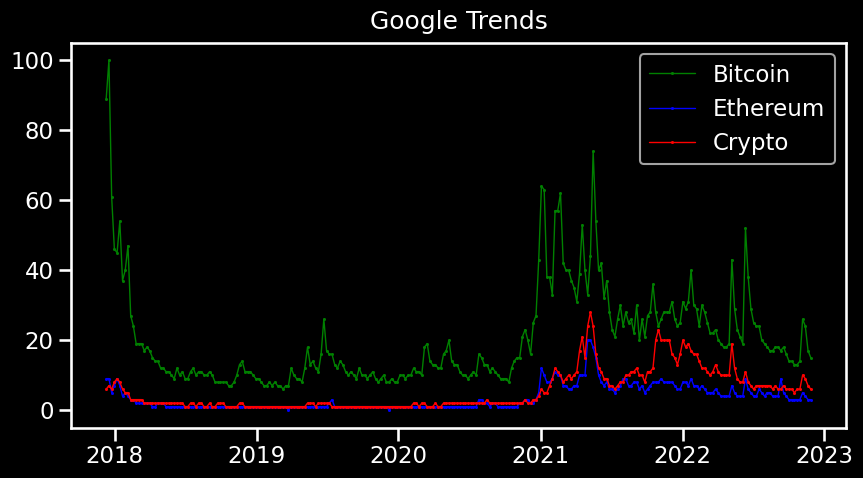

In [65]:
#@title
#@title Google Trends
import seaborn as sns
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
# Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()


pytrend.build_payload(kw_list=['Bitcoin', 'Ethereum','Crypto'])

# Interest Over Time
interest_over_time_df = pytrend.interest_over_time()
df=interest_over_time_df

plt.plot( 'Bitcoin', 'y1', data=df, marker='x', color='green',linestyle='-', linewidth=1,ms=1.5 )
plt.plot( 'Ethereum', 'y2', data=df, marker='x', color='blue',linestyle='-', linewidth=1,ms=1.5 )
plt.plot( 'Crypto', 'y3', data=df, marker='x', color='red',linestyle='-', linewidth=1,ms=1.5 )

#plt.plot( 'Cosmos Crypto', 'y5', data=df, marker='x', color='red',linestyle='-', linewidth=1,ms=1.5 )
plt.legend()


# title
plt.title('Google Trends', loc='center',pad=10)


In [66]:
#@title
#@title Crypto Fear & Greed Index

import requests

from datetime import datetime
import time
import json
from google.colab import data_table
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt



#General Information table
response = requests.get("https://api.alternative.me/fng/?limit=0")
output = response.text
json_parsed = json.loads(output)

df = pd.json_normalize(json_parsed)


df1 = pd.concat([pd.json_normalize(x) for x in df['data'].values.tolist()])
timeseries = df1['timestamp']
df1['date'] = pd.to_datetime(df1['timestamp'], unit = 's')

df_fear_greed = pd.concat([df1['date'], df1['value']], axis=1)
df3 = pd.concat([df1['date'], df1['value_classification']])

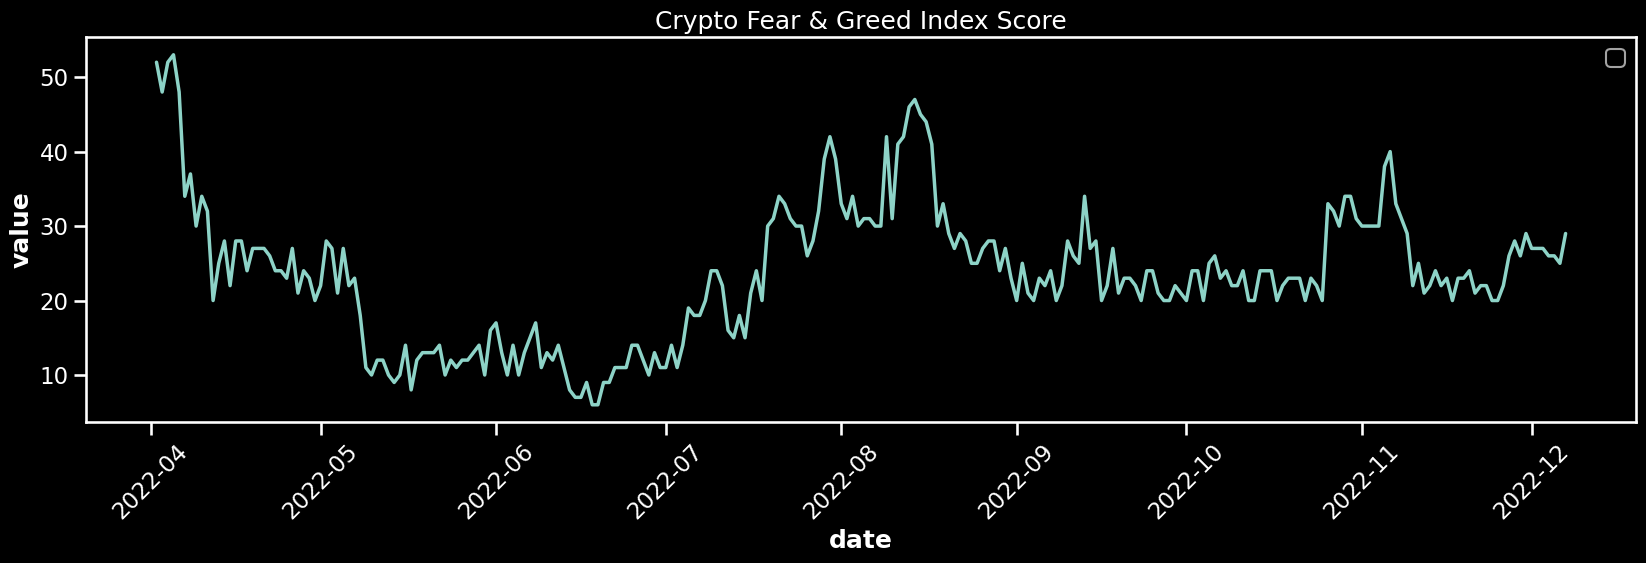

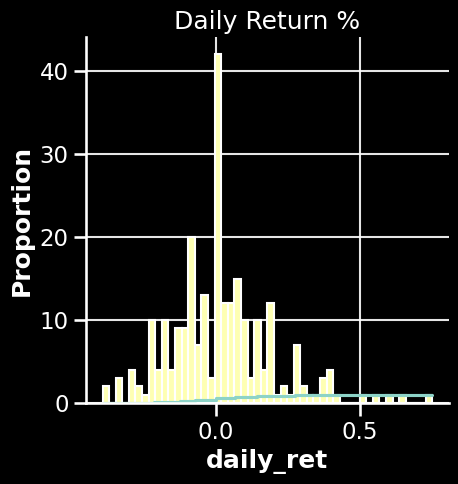

In [67]:
#@title
#@title


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.style.use("dark_background")
#sns.set_theme(style="darkgrid")

#Choose the date range
df_fear_greed = df_fear_greed[(df_fear_greed['date'] > '2022-04-01')]

df_fear_greed['value'] = df_fear_greed['value'].astype(int)
 
plt.figure(figsize=(20, 5))

sns.lineplot(data=df_fear_greed, linewidth=2.5, x="date", y="value", sort=False)
#sns.lineplot(df_fear_greed=df, linewidth=2.5, x="date", y="TotalCapMrktCurUSD")
plt.title('Crypto Fear & Greed Index Score')

plt.xticks(rotation=45)

plt.legend()


df_fear_greed.head(1)


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

df_fear_greed['daily_ret'] = df_fear_greed['value'].pct_change(1)

ECDF = sns.displot(df_fear_greed, x="daily_ret", kind="ecdf")

Histogram = df_fear_greed['daily_ret'].hist(bins = 50)


plt.title('Daily Return %')

plt.show()

# Technical Analysis

In [68]:
#@title S&P 500
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import talib as ta

ticker='SPY'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['longName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')


[*********************100%***********************]  1 of 1 completed


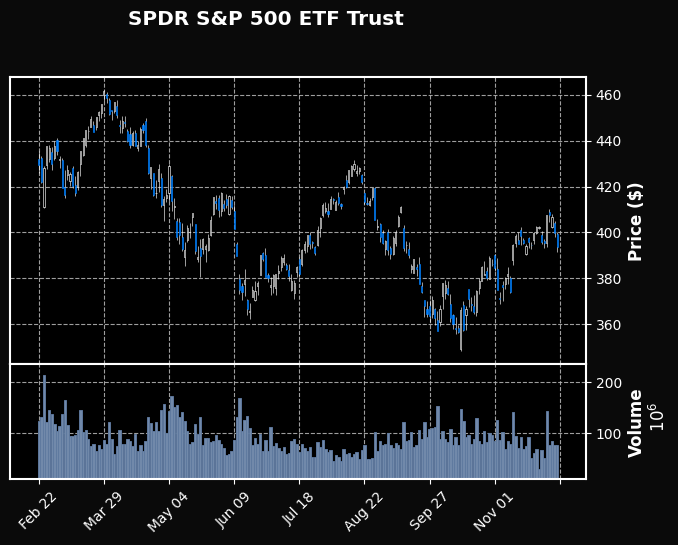

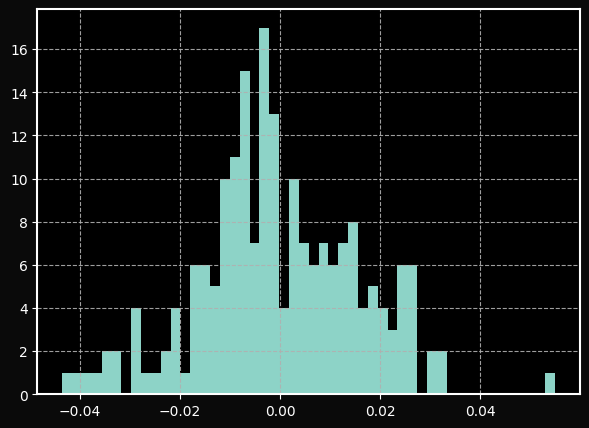

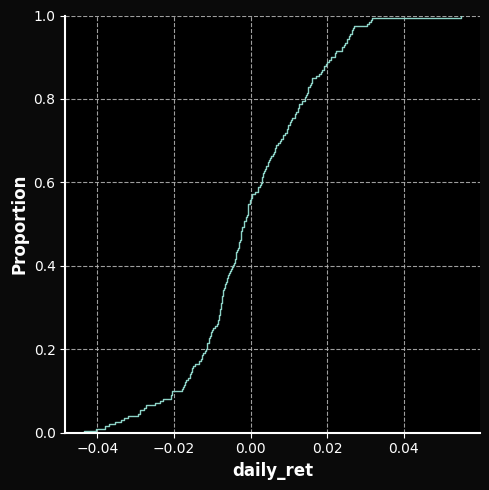

In [69]:
#@title
import mplfinance as fplt

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )

data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))

sns.displot(data, x="daily_ret", kind="ecdf")



[*********************100%***********************]  1 of 1 completed



Related News – ^VIX

– Stock Market News for Dec 6, 2022
– Why Monday’s stock-market rout should be a wake up call for investors
– Stock Market News for Dec 5, 2022
– Big Test in the Market This Week
– Stock Market News for Dec 2, 2022
– Stock Market News for Dec 1, 2022
– This trader sees a 43% drop  for the S&P 500 and says to take shelter in these ETFs instead.


/usr/local/lib/python3.8/dist-packages/mplfinance/plotting.py:678: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



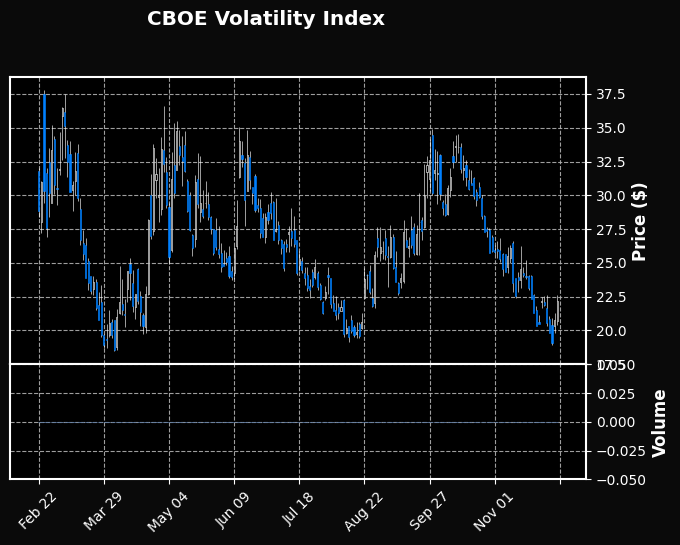

Text(0.5, 1.0, 'Daily Return %')

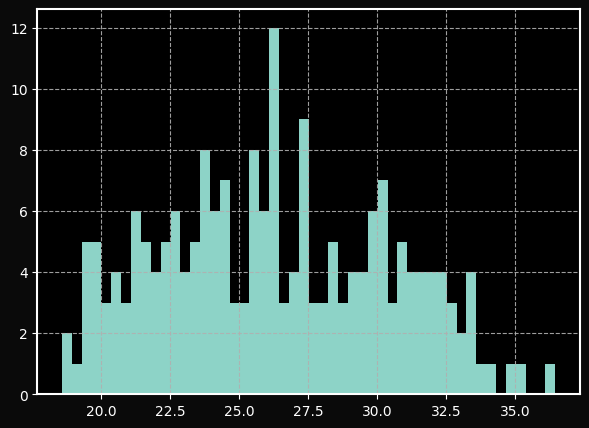

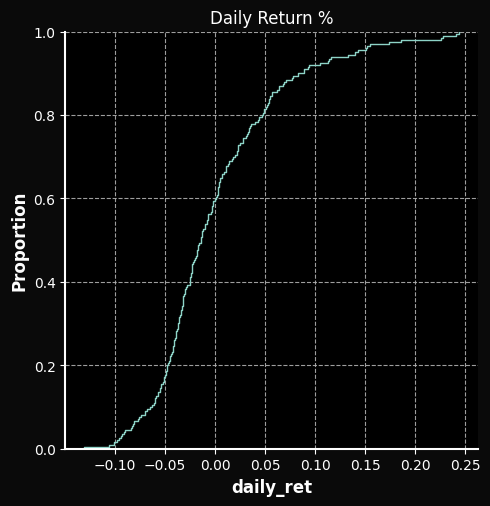

In [70]:
#@title  VIX
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='^VIX'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')

fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])

fig.update_layout(
    title=Name,
    yaxis_title='Price',
   
)

fig.show()
ticker_y.info

print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass

import mplfinance as fplt

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )

data['daily_ret'] = data['Close'].pct_change(1)
data['Close'].hist(bins = 50,figsize = (7,5))
sns.displot(data, x="daily_ret", kind="ecdf")


plt.title('Daily Return %')

[*********************100%***********************]  1 of 1 completed



Related News – QQQ

– Jobless Claims, Goods Orders, Airline Metrics Up Ahead of Holiday
– Stocks surge at open, Nasdaq solidly in the green
– Nasdaq rips higher, S&P 500 gains as tech lifts stocks
– ETF investors are ‘trying to get back to core set of exposures’ amid surging inflows, expert says
– How Every Leveraged ETF Can Cost Investors Money
– Nasdaq leads market declines, British pound loses value against U.S. dollar
– Economic Data Gradually Dwindles: Jobless Claims, Productivity & More


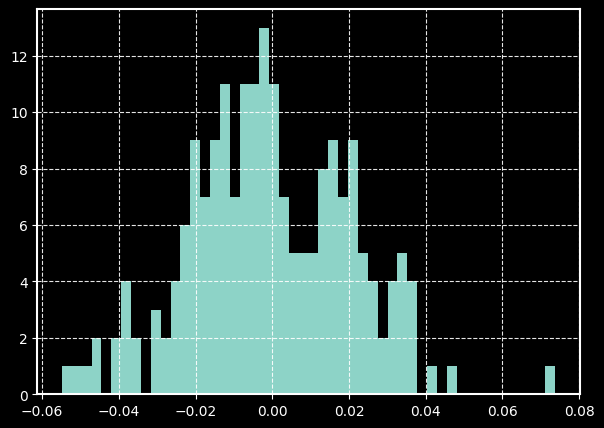

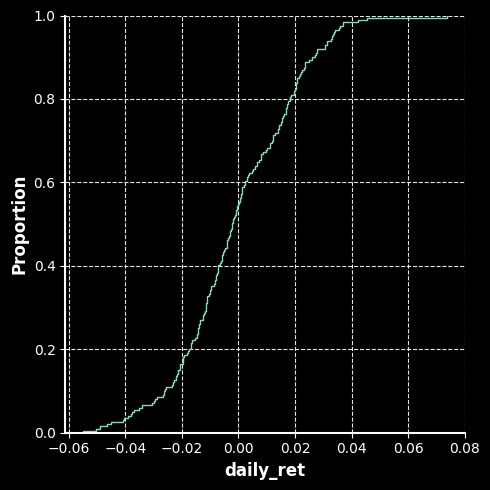

In [71]:
#@title NASDAQ
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

plt.style.use("dark_background")

ticker='QQQ'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['longName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')

fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])

fig.update_layout(
    title=Name,
    yaxis_title='Price',
   
)

fig.show()
ticker_y.info

print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass

data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))
sns.displot(data, x="daily_ret", kind="ecdf")

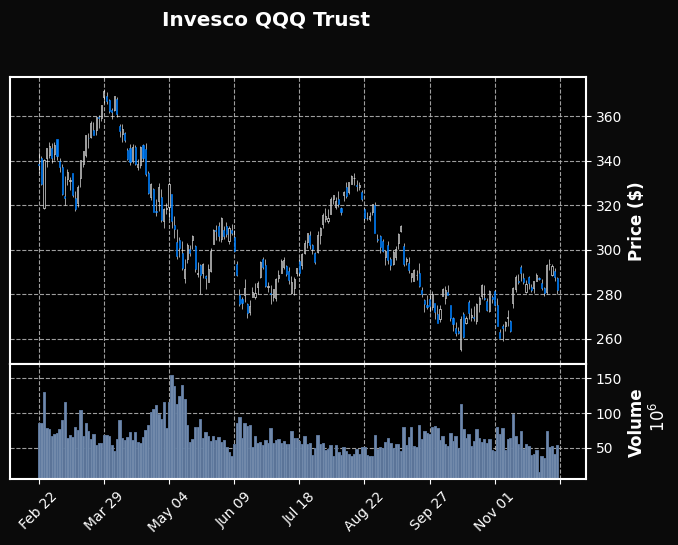

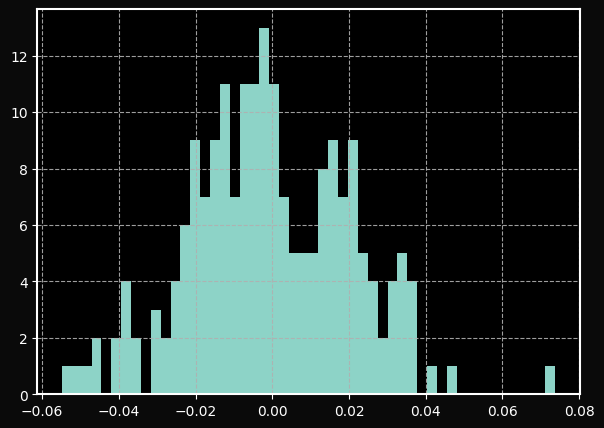

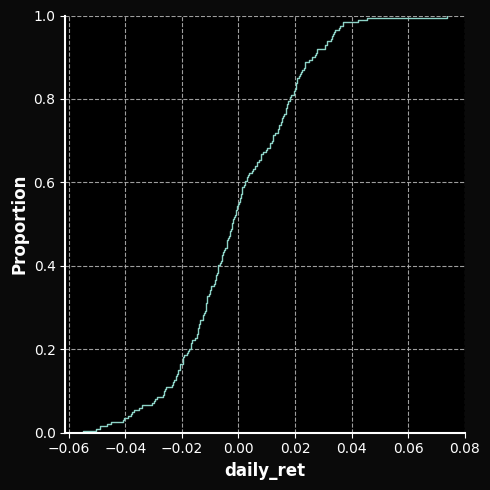

In [72]:
#@title

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )


data['daily_ret'] = data['Close'].pct_change(1)
data['daily_ret'].hist(bins = 50,figsize = (7,5))
sns.displot(data, x="daily_ret", kind="ecdf")

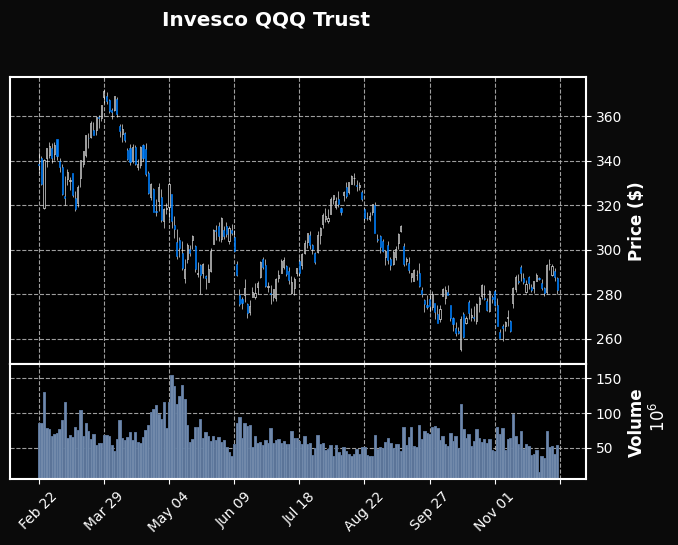

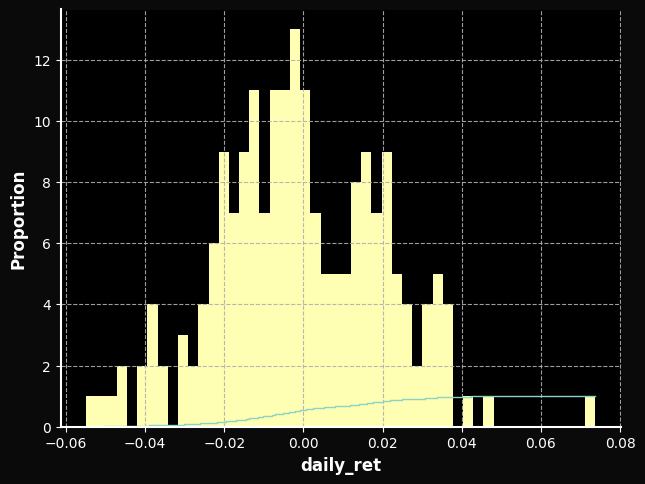

In [73]:
#@title

fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )


data['daily_ret'] = data['Close'].pct_change(1)

sns.displot(data, x="daily_ret", kind="ecdf")

data['daily_ret'].hist(bins = 50,figsize = (7,5))

[*********************100%***********************]  1 of 1 completed



Related News – BTC-USD



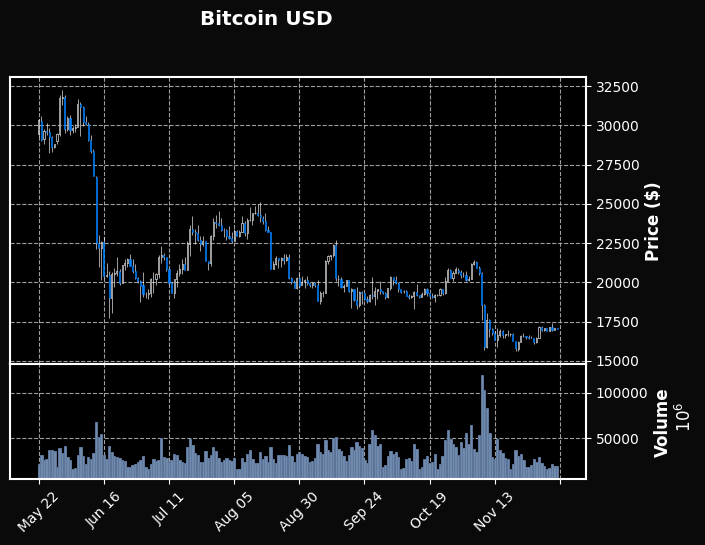

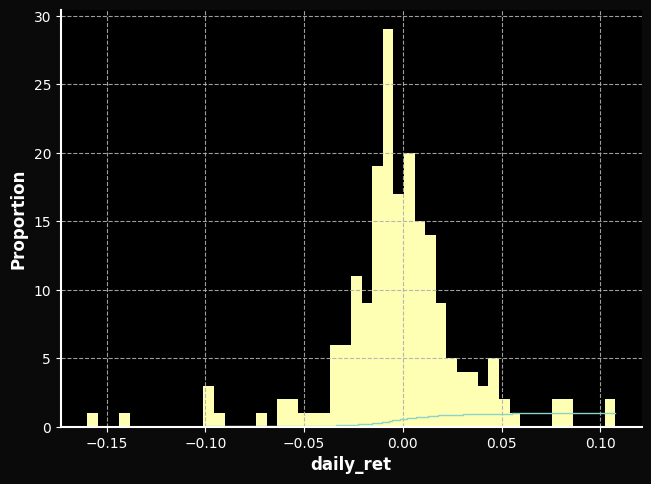

In [74]:
#@title Bitcoin
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='BTC-USD'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')

fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])

fig.update_layout(
    title=Name,
    yaxis_title='Price',
   
)

fig.show()
ticker_y.info

print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass
  
fplt.plot(
            data,
            type='candle',
            style='mike',
            title=Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )
data['daily_ret'] = data['Close'].pct_change(1)

sns.displot(data, x="daily_ret", kind="ecdf")

data['daily_ret'].hist(bins = 50,figsize = (7,5))

[*********************100%***********************]  1 of 1 completed



Related News – ETH-USD

– Warren Buffett 'Loves' China’s BYD Despite Selldown, EV Executive Says
– Market Rally Wipes Out Powell Gains As Apple, Exxon Skid; What To Do Now
– Singapore Reveals $3.6 Million Virtual Production Innovation Fund, Partnerships with U.K.’s NFTS, Epic Games
– U.S. Watchdog Sanctions KPMG Firms, Audit Professionals
– Global Care Capital Announces Closing of Acquisition of MK Highway Corp
– Syndax Announces Pricing of $150 Million Public Offering of Common Stock
– E-cigarette maker Juul reaches settlement with nearly 10,000 plaintiffs


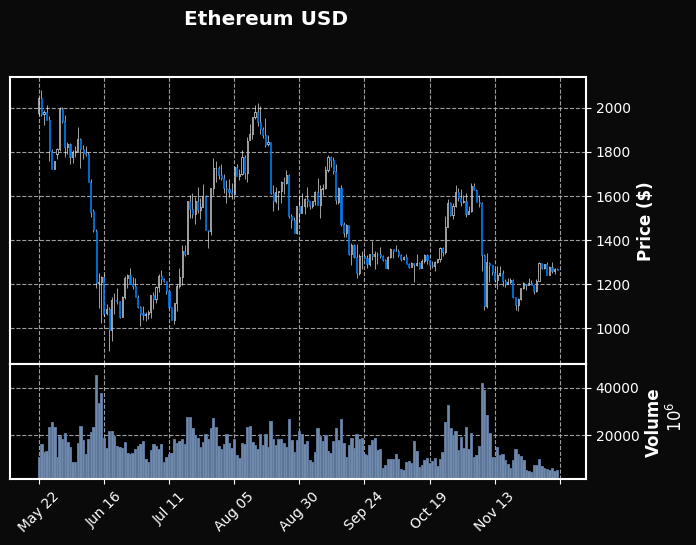

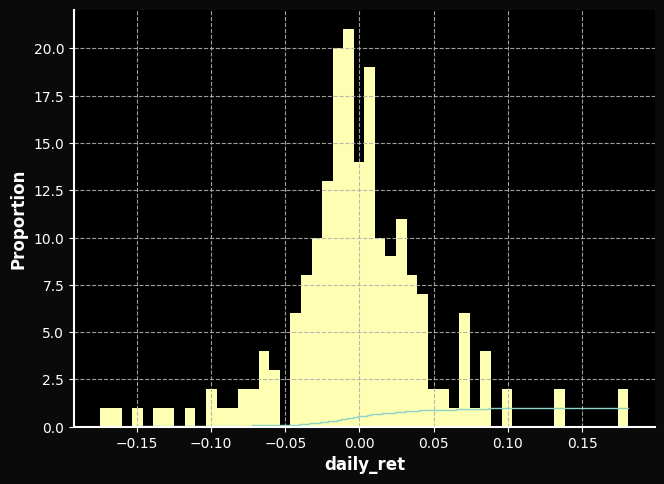

In [75]:
#@title Ethereum
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

ticker='ETH-USD'


ticker_y = yf.Ticker(ticker)
Name = ticker_y.info['shortName']
ticker_y.info

data = yf.download(tickers=ticker, period='200d')

fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])

fig.update_layout(
    title=Name,
    yaxis_title='Price',
   
)

fig.show()
ticker_y.info

print('')
print('Related News – ' +ticker)
print('')

try:
  for i in range(1,10):
    print('– ' + ticker_y.news[i]['title'])

except Exception:
  pass

  
fplt.plot(
            data,
            type='candle',
            style='mike',
            title =Name,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            )

data['daily_ret'] = data['Close'].pct_change(1)

sns.displot(data, x="daily_ret", kind="ecdf")

data['daily_ret'].hist(bins = 50,figsize = (7,5))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DXY: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


<Figure size 640x480 with 0 Axes>

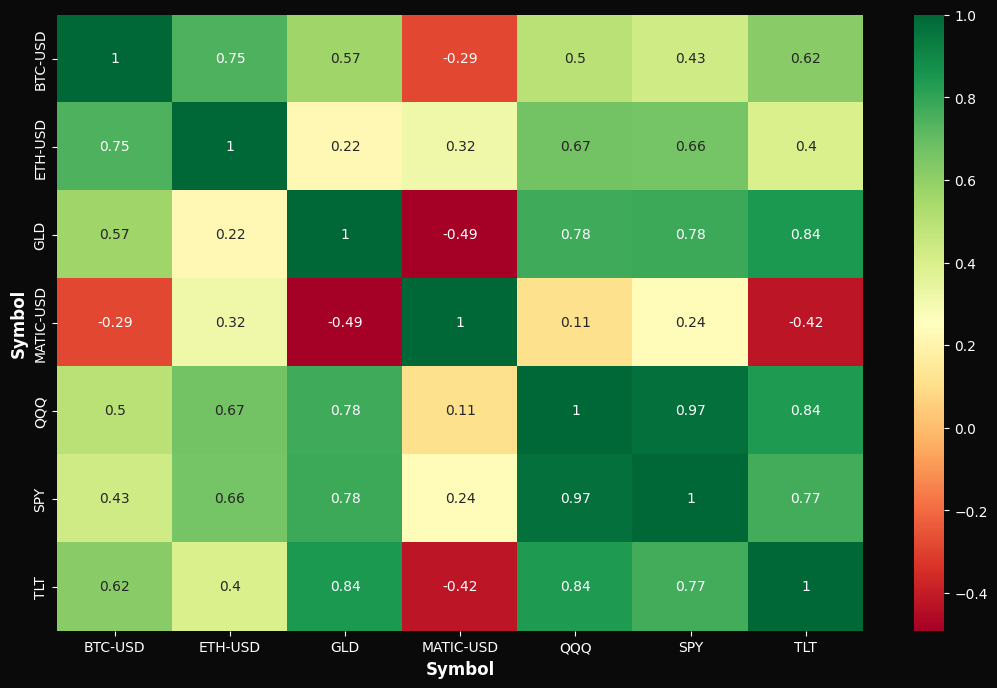

<Figure size 640x480 with 0 Axes>

In [76]:
#@title Correlation

import numpy as np 
import pandas as pd 
# Used to grab the stock prices, with yahoo 
import pandas_datareader as web 
from datetime import datetime 
# To visualize the results 
import matplotlib.pyplot as plt 
import seaborn

start = datetime(2022,9, 1)
symbols_list = [yahoo_id,'SPY', 'QQQ', 'ETH-USD', 'BTC-USD', 'TLT', 'DXY', 'GLD']
#array to store prices
symbols=[]

#array to store prices
symbols=[]
for ticker in symbols_list:     
    
    r = yf.download(tickers=ticker, period='200d')
    # add a symbol column   
    r['Symbol'] = ticker    
    symbols.append(r)
# concatenate into df
df = pd.concat(symbols)
df = df.reset_index()
df = df[['Date', 'Close', 'Symbol']]
df.head()
df_pivot=df.pivot('Date','Symbol','Close').reset_index()
df_pivot.head()
corr_df = df_pivot.corr(method='pearson')
#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
#del corr_df.index.name
corr_df.head(10)
plt.figure(figsize=(13, 8))
seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn')
plt.figure()

# Search Token


In [77]:

CoinGecko_id = "star-atlas" #@param {type:"string"}
yahoo_id = "MATIC-USD" #@param {type:"string"}


# Intraday Fundamentals

Connect to screener database

Trade Management

In [78]:
#@title Fundamentals

import requests
import datetime
import time
import json
from google.colab import data_table
from pycoingecko import CoinGeckoAPI
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq


cg = CoinGeckoAPI()

  
response = requests.get("https://api.coingecko.com/api/v3/coins/{}".format(CoinGecko_id))
output = response.text
json_parsed = json.loads(output)
  

links = 'Complete list: '+str(json_parsed['links'])
chat_url = 'Chat: '+str(json_parsed['links']['chat_url'])
Twitters = 'Twitter: '+str('https://twitter.com/')+str(json_parsed['links']['twitter_screen_name'])
homepage = 'Homepage: '+str(json_parsed['links']['homepage'])
subreddit_url =  'Reddit: ' +str(json_parsed['links']['subreddit_url'])
pd.set_option('display.width', 10)

print('')
print('WEB Links')
print('')
print(homepage)
print(Twitters)
print(subreddit_url)
print(chat_url)


print(links)

print('')  
print('MARKET DATA')  
print('')  


market_cap = json_parsed['market_data']['market_cap']['usd']
circulating_supply = json_parsed['market_data']['circulating_supply']
# circulating_supply.astype(int) 
current_price = json_parsed['market_data']['current_price']['usd']
# current_price.astype(int) 
fdv_to_tvl_rati = json_parsed['market_data']['fdv_to_tvl_ratio']
# fdv_to_tvl_ratio.astype(int) 
fully_diluted_valuation = json_parsed['market_data']['fully_diluted_valuation']
# fully_diluted_valuation
max_supply = json_parsed['market_data']['max_supply']
mcap_to_tvl_ratio = json_parsed['market_data']['mcap_to_tvl_ratio']
total_supply = json_parsed['market_data']['total_supply']
#total_value_locked = json_parsed['market_data']['total_value_locked']['usd']
total_volume = json_parsed['market_data']['total_volume']['usd']

float_rotation_24h = total_volume / market_cap
circulating_cap = current_price * json_parsed['market_data']['circulating_supply']
total_cap = current_price * total_supply


def max_cap(current_price, max_supply):
  """
    Calculation of maximum capitalization 
     Requiring current price and maximum supply
  """
  if max_supply is not None :
    max_cap = current_price * max_supply
  else :
    max_cap = 0
  return max_cap

max_cap = max_cap(current_price, max_supply)



def supply_expansion_multiple(current_price, max_supply):
  """
    Calculating supply expansion multiple
    Requiring maximum supply and circulating supply
  """
  if max_supply is None :
    supply_expansion_multiple = 0
    
  elif circulating_supply is 0:
    supply_expansion_multiple == 0
  
  else :
    supply_expansion_multiple = max_supply  / circulating_supply
  
  return supply_expansion_multiple


supply_expansion_multiple = supply_expansion_multiple(current_price, max_supply)


"""
def market_cap_dilution_ratio(fully_diluted_valuation, market_cap):


  if fully_diluted_valuation or market_cap is None :
    market_cap_dilution_ratio == 0
    
  elif fully_diluted_valuation or market_cap is 0:
    market_cap_dilution_ratio == 0

  elif fully_diluted_valuation or market_cap is {}:
    market_cap_dilution_ratio == 0

  else :
    market_cap_dilution_ratio =  fully_diluted_valuation / market_cap
  
  return market_cap_dilution_ratio


market_cap_dilution_ratio = market_cap_dilution_ratio(fully_diluted_valuation, market_cap)
"""

print('')  

circulating_versus_max = circulating_supply/total_supply
dict_custom = {}
dict_custom['float_rotation_24h'] = float_rotation_24h
dict_custom['supply_expansion_multiple'] = supply_expansion_multiple
dict_custom['circulating_versus_max'] = circulating_versus_max


df_market = {}
df_market['market_cap'] = market_cap
#Final been up what is on the national emergency, informative or what basket is something the P is the spaciousness up to Sarah  ankedat1['circulating_supply'] = circulating_supply
df_market['current_price'] = current_price
# df_market['fdv_to_tvl_ratio'] = fdv_to_tvl_ratio#
df_market['fully_diluted_valuation'] = fully_diluted_valuation
# ankedat1['max_supply'] = max_supply
df_market['mcap_to_tvl_ratio'] = mcap_to_tvl_ratio
df_market['total_supply'] = total_supply
#df_market['total_value_locked'] = total_value_locked
df_market['mcap_to_tvl_ratio'] = mcap_to_tvl_ratio
df_market['total_volume'] = total_volume


df_market




print('          ')  
print('PRICE ACTION')  
price_change_percentage_7d = json_parsed['market_data']['price_change_percentage_7d']
price_change_percentage_14d = json_parsed['market_data']['price_change_percentage_14d']
price_change_percentage_30d = json_parsed['market_data']['price_change_percentage_30d']
price_change_percentage_60d = json_parsed['market_data']['price_change_percentage_60d']
price_change_percentage_200d = json_parsed['market_data']['price_change_percentage_200d']
price_change_percentage_1y = json_parsed['market_data']['price_change_percentage_1y']



dict_return = {}
dict_return['price_change_percentage_7d'] = price_change_percentage_7d
dict_return['price_change_percentage_14d'] = price_change_percentage_14d
dict_return['price_change_percentage_30d'] = price_change_percentage_30d
dict_return['price_change_percentage_60d'] = price_change_percentage_60d
dict_return['price_change_percentage_200d'] = price_change_percentage_200d
dict_return['price_change_percentage_1y'] = price_change_percentage_1y

print(dict_return)



category = json_parsed['categories']

print('')  
print('CATEGORIES')  
print(category)
  



description  = [] 
pd.set_option('display.width', 10)
pd.set_option("display.max_rows", None, "display.max_columns", None)
description = json_parsed['description']['en']

print('')  
print('DESCRIPTION: ')
print(description)


links = json_parsed['links']



#




<>:89: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:89: SyntaxWarning:

"is" with a literal. Did you mean "=="?




WEB Links

Homepage: ['https://staratlas.com', '', '']
Twitter: https://twitter.com/staratlas
Reddit: https://www.reddit.com/r/staratlas
Chat: ['https://www.facebook.com/StarAtlasMMO', 'https://discord.gg/staratlas', '']
Complete list: {'homepage': ['https://staratlas.com', '', ''], 'blockchain_site': ['https://solscan.io/token/ATLASXmbPQxBUYbxPsV97usA3fPQYEqzQBUHgiFCUsXx', 'https://explorer.solana.com/address/ATLASXmbPQxBUYbxPsV97usA3fPQYEqzQBUHgiFCUsXx', '', '', '', '', '', '', '', ''], 'official_forum_url': ['', '', ''], 'chat_url': ['https://www.facebook.com/StarAtlasMMO', 'https://discord.gg/staratlas', ''], 'announcement_url': ['https://medium.com/star-atlas', ''], 'twitter_screen_name': 'staratlas', 'facebook_username': '', 'bitcointalk_thread_identifier': None, 'telegram_channel_identifier': 'staratlasgame', 'subreddit_url': 'https://www.reddit.com/r/staratlas', 'repos_url': {'github': [], 'bitbucket': []}}

MARKET DATA


          
PRICE ACTION
{'price_change_percentage_7d': 

<ipython-input-78-9bdc091a5969>:89: SyntaxWarning:

"is" with a literal. Did you mean "=="?



In [79]:

#@title Charts

 
import datetime
import time
import json
from google.colab import data_table
from pycoingecko import CoinGeckoAPI
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq


cg = CoinGeckoAPI()

"""
1 - 2 days: 30 minutes
3 - 30 days: 4 hours
31 days and beyond: 4 days
"""
#chart  1
a = cg.get_coin_ohlc_by_id(id=CoinGecko_id, vs_currency='usd', days = 'max' )
df  = pd.DataFrame(data=a, columns = ['Date','Open','High', 'Low', 'Close'])
df['datetime'] = pd.to_datetime(df['Date'], unit='ms')
fig2 = go.Figure(data=[go.Candlestick(x=df['datetime'],open=df['Open'], high=df['High'],low=df['Low'], close=df['Close'])])                    
fig2.show()

#chart   2
b = cg.get_coin_ohlc_by_id(id=CoinGecko_id, vs_currency='usd', days = 180 )
df2  = pd.DataFrame(data=b, columns = ['Date','Open','High', 'Low', 'Close'])
df2['datetime'] = pd.to_datetime(df2['Date'], unit='ms')
fig3 = go.Figure(data=[go.Candlestick(x=df2['datetime'],open=df2['Open'], high=df2['High'],low=df2['Low'], close=df2['Close'])])                    
fig3.show()

#chart   3
b = cg.get_coin_ohlc_by_id(id=CoinGecko_id, vs_currency='usd', days = 30 )
df2  = pd.DataFrame(data=b, columns = ['Date','Open','High', 'Low', 'Close'])
df2['datetime'] = pd.to_datetime(df2['Date'], unit='ms')
fig3 = go.Figure(data=[go.Candlestick(x=df2['datetime'],open=df2['Open'], high=df2['High'],low=df2['Low'], close=df2['Close'])])                    
fig3.show()


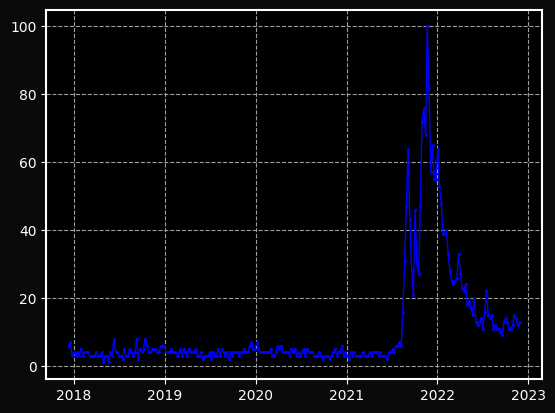

In [80]:
#@title Google Trends
pytrend = TrendReq()

# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
keyword = str(CoinGecko_id)
keyword = keyword.replace('-',' ')
pytrend.build_payload(kw_list=[keyword])


interest_over_time_df = pytrend.interest_over_time()
df_Google=interest_over_time_df

#print(interest_over_time_df.tail(10))
# multiple line plot
# multiple line plot
plt.plot( keyword, 'y1', data=df_Google, marker='x', color='blue',linestyle='-', linewidth=1,ms=1.5 )

In [82]:
#@title  Project Recent Tweets
import configparser
config_file = "/content/drive/MyDrive/workspace/config.ini"
config_obj = configparser.ConfigParser()
config_obj.read(config_file)

Twitter = config_obj["Twitter_API"]

consumer_key = Twitter["consumer_key"]
consumer_secret = Twitter["consumer_secret"]
access_token = Twitter["access_token"]
access_token_secret = Twitter["access_token_secret"]


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

user_name =str(json_parsed['links']['twitter_screen_name'])

def twitter_rept(user_name):
    """
    
    Generating text data of recent tweets

    """

    user =  api.user_timeline(screen_name = user_name )

    for tweet in user:
      
        print(tweet.created_at)

        print(tweet.text)

        print("------------------------------------------------------------------") 

    return 
    
twitter_rept(user_name)

2022-12-06 17:02:27
@rccarlsonjr https://t.co/axyybmdJlv
------------------------------------------------------------------
2022-12-06 15:55:53
@onursonmeznet @PolkastarterGG @at_mwagner @pabloiquiroga @WeAreStarAtlas @animocabrands @Santiacc_ @DominicVain… https://t.co/eAyR8THT6Y
------------------------------------------------------------------
2022-12-06 15:50:44
@Carlitosmeola1 https://t.co/y9H3PqIeUF
------------------------------------------------------------------
2022-12-06 15:50:17
@JonathanGuilla3 https://t.co/3mof1HgMBo
------------------------------------------------------------------
2022-12-06 14:29:21
ICYMI: In this month's edition of the Atlas Star, we cover everything from the R2 Showroom, to the Golden Age, to t… https://t.co/ex2DojDUtu
------------------------------------------------------------------
2022-12-05 19:17:45
RT @WeAreStarAtlas: There's only a few hours left to nominate your favorite community members in the first annual #JoniAwards!

Nominations…
-------